# Test the two models on a June 6th, 2023 

In [1]:
from wrf import getvar, get_cartopy, cartopy_ylim, cartopy_xlim
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap
import matplotlib as mpl
from cartopy import crs as ccrs, feature as cfeature
import stats 
import joblib
import pickle
from sklearn.model_selection import StratifiedKFold
from scipy.signal import correlate2d
from sklearn.ensemble import RandomForestClassifier
import imblearn

/Users/jmceachern/miniconda3/envs/lightningwrf/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Load in the data and the models 

In [44]:
# case study date 
date = ('2023','06','06')
feature_lis = ['pw','cape','cin','T2','slp','ctt','K','SWI','LI','SI','wmax','Q']
times = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
shape = (417, 627)

In [45]:
# retreive the saved X and y data for a given date and time
test_dict = {}

for tt in times:
    y_test, X_test = stats.retreive_X_y_test(date,tt,feature_lis,shape)
    y_test = np.where(y_test>0,1,0)

    test_dict[f'y{tt}'] = y_test
    test_dict[f'X{tt}'] = X_test

In [46]:
# get the wrf ds to extract latitude and longitude for plotting 
wrf_ds = stats.get_wrf('wrfout_d02_2023-06-06_00_00_00')
lat = getvar(wrf_ds,'lat')
lon = getvar(wrf_ds,'lon')

get_wrf:  9.5367431640625e-07


In [47]:
# dictionary of longtitudes and latitudes corresponding to flashes for each time in the case study (this is used for plotting)
lat_dict = {}
lon_dict = {}

for tt in times:
    y = test_dict[f'y{tt}']
    y = stats.reconstruct_domain(y,shape)
    lat_lis = []
    lon_lis = []
    for i, val in enumerate(y.flatten()):
        if val==1:
            lat_lis.append(lat.values.ravel()[i])
            lon_lis.append(lon.values.ravel()[i])

    lat_dict[f'lat{tt}'] = lat_lis
    lon_dict[f'lon{tt}'] = lon_lis

## Make the prediction 
Runtime: ~4 minutes

In [48]:
# dictionary of probabilities predicted by the RF
p_dict_up = {}
p_dict_w = {}

for tt in times:
    X = test_dict[f'X{tt}']
    # find the probabilities calculated by each model
    pup = RFup.predict_proba(X)[:,1]
    pw = RFw.predict_proba(X)[:,1]

    # add predictions to dictionary where each key is a different time 
    p_dict_up[f'p{tt}'] = pup
    p_dict_w[f'p{tt}'] = pw

### Probability distributions for both models

Text(0.5, 0.98, 'Upsampled dist                         Weighted dist')

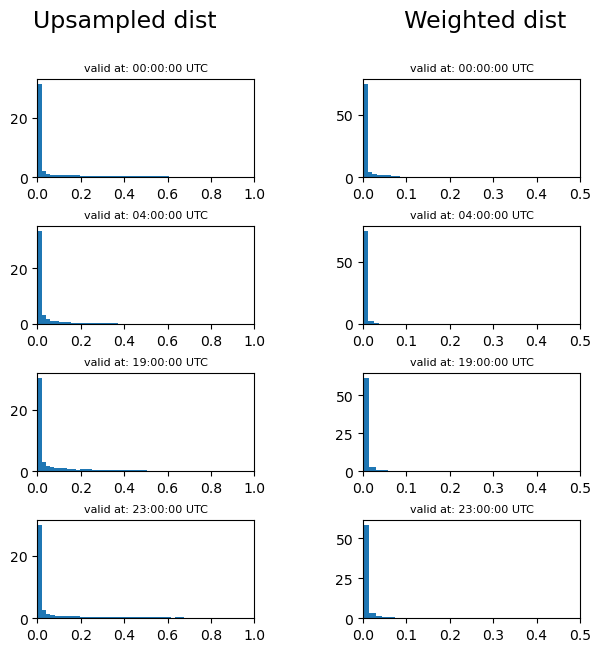

In [59]:
time_lis = ['00','04','19','23']

fig, ax = plt.subplots(4,2,
                        figsize=(7,7))

tix = 0 # to index the time list 
for i in range(4): # rows
    for j in range(2): # columns

        tt = time_lis[tix]

        if j == 0:
            p1d = p_dict_up[f'p{tt}']
            ax[i,j].hist(p1d,bins=50,density=True)
            ax[i,j].set_title(f'valid at: {tt}:00:00 UTC', fontsize=8)
            ax[i,j].set_xlim(0,1)


        # the column of weighted predictions for different times
        if j == 1:
            p1d = p_dict_w[f'p{tt}']
            ax[i,j].hist(p1d,bins=50,density=True)
            ax[i,j].set_title(f'valid at: {tt}:00:00 UTC', fontsize=8)
            ax[i,j].set_xlim(0,0.5)

    tix+=1

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(      'Upsampled dist                         Weighted dist',size=17)
# plt.savefig('figures/CaseStudy1.png',bbox_inches='tight')


## Calculate the evaluation metrics from the stratified 3-fold cross-validation 

In [2]:
training_dates = [('2024','06','05'),('2024','06','06'),('2024','06','07'),('2024','06','09'),('2024','06','10'),('2024','06','11'),('2024','06','12'),('2024','06','13'),('2024','06','14'),('2024','06','15'),('2024','06','16'),('2024','06','18'),('2024','06','19'),('2024','06','20'),('2024','06','21'),('2024','07','14'),('2024','07','15'),('2024','07','16'),('2024','07','17'),('2024','07','19'),('2024','07','20'),('2024','07','21'),('2024','07','22'),('2024','07','23'),('2024','07','24'),('2024','07','25'),('2024','07','26'),('2024','07','27')]
# training_dates = [('2024','06','05'),('2024','06','06')]
feature_lis = ['pw','cape','cin','T2','slp','ctt','K','SWI','LI','SI','wmax','Q']
shape = (417, 627)

y_train_all, X_train_all = stats.retreive_X_y_train_small(training_dates,feature_lis,shape)
y_train_bi = np.where(y_train_all>1,1,0)

In [8]:
WriteIt = False

if WriteIt:
    k = 3
    # calculate the validation metrics and save them to a dictionary called validation_dict
    stats.cross_validation(X_train_all,y_train_bi,k)
else:
    # load the validation dictionary calculated from the 3-fold cross validation 
    with open('validation/validation_dict.pkl','rb') as f:
        validation_dict = pickle.load(f)


## Visualize the verification results

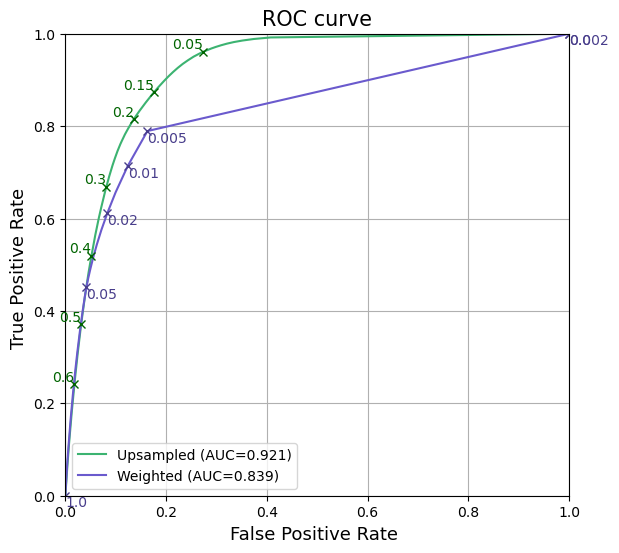

In [99]:
AUCup = validation_dict['AUCup']
AUCw = validation_dict['AUCw']
threshs = np.array(validation_dict['threshs'])[0,:]

plt.figure(figsize=(6.5,6))
plt.plot(validation_dict['FPRup'],validation_dict['TPRup'], label=f'Upsampled (AUC={round(AUCup,3)})', color='mediumseagreen')
plt.plot(validation_dict['FPRw'],validation_dict['TPRw'], label=f'Weighted (AUC={round(AUCw,3)})', color='slateblue')

display_thresh_up = np.array([0.05,0.15,0.2,0.3,0.4,0.5,0.6])
display_thresh_w = np.array([0,0.002,0.005,0.01,0.02,0.05,1])

for i in range(len(display_thresh_up)):
    # find the index for each threshold
    iup = (np.abs(threshs-display_thresh_up[i])).argmin()

    plt.plot(validation_dict['FPRup'][iup],validation_dict['TPRup'][iup],'x',color='darkgreen')
    plt.text(validation_dict['FPRup'][iup],validation_dict['TPRup'][iup],f'{round(display_thresh_up[i],3)}', color='darkgreen',
            verticalalignment='bottom', horizontalalignment='right')

    # find the index for each threshold
    iw = (np.abs(threshs-display_thresh_w[i])).argmin()

    plt.plot(validation_dict['FPRw'][iw],validation_dict['TPRw'][iw],'x',color='darkslateblue')
    plt.text(validation_dict['FPRw'][iw],validation_dict['TPRw'][iw],f'{round(display_thresh_w[i],3)}', color='darkslateblue',
            verticalalignment='top', horizontalalignment='left')

plt.xlabel('False Positive Rate ',fontsize=13)
plt.ylabel('True Positive Rate ',fontsize=13)
plt.title('ROC curve',fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.legend()

plt.savefig('figures/ROC.png',bbox_inches='tight')

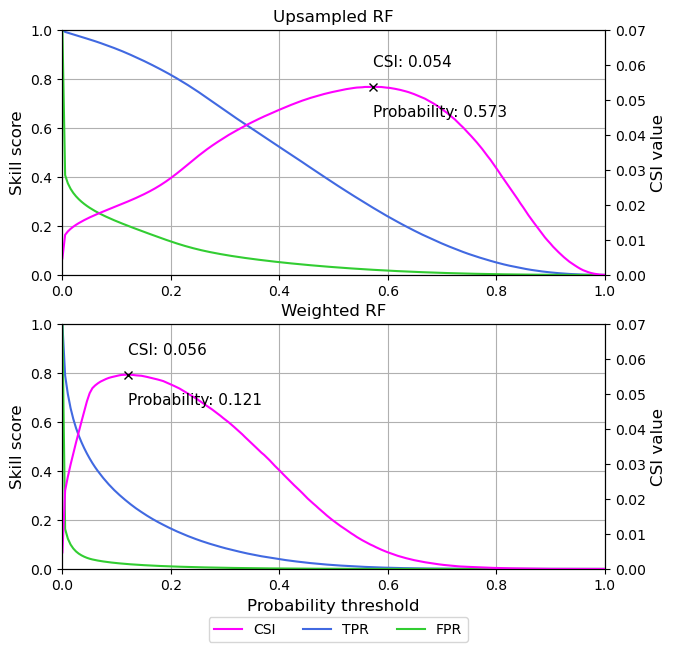

In [41]:
fig, ax = plt.subplots(2,1, figsize=(7,7))

cases = ['up','w']

for i,case in enumerate(cases):
    # tpr, fpr, thresh, AUC, CSI = calc_deterministic_verification(p,y_test)

    ax2 = ax[i].twinx()

    CSI = validation_dict[f'CSI{case}']
    l1 = ax2.plot(threshs, CSI,label='CSI',color='fuchsia')
    l2 = ax[i].plot(threshs, validation_dict[f'TPR{case}'],label='TPR',color='royalblue')
    l3 = ax[i].plot(threshs, validation_dict[f'FPR{case}'],label='FPR',color='limegreen')

    idx = CSI.argmax()
    ax2.plot(threshs[idx],CSI[idx],'x',color='black')
    ax2.text(threshs[idx],CSI[idx]+0.005,f'CSI: {round(CSI[idx],3)}', color='black', fontsize=11,
            verticalalignment='bottom', horizontalalignment='left')
    ax2.text(threshs[idx],CSI[idx]-0.005,f'Probability: {round(threshs[idx],3)}', color='black', fontsize=11,
            verticalalignment='top', horizontalalignment='left')

    ax[i].set_xlim(0,1)
    ax[i].set_ylim(0,1)
    ax[i].set_ylabel('Skill score',fontsize=12)
    ax2.set_ylabel('CSI value',fontsize=12)

    if i ==0:
        ax[i].set_title('Upsampled RF',fontsize=12)

    if i ==1:
        ax[i].set_xlabel('Probability threshold',fontsize=12)
        ax[i].set_title('Weighted RF',fontsize=12)
    ax2.set_ylim(0,0.07)
    ax[i].grid()

ls = l1+l2+l3
labs = [l.get_label() for l in ls]
fig.legend(ls,labs, loc='lower center', ncol=3)
plt.savefig('figures/DeterministicValidation.png',bbox_inches='tight')

## Case Study: June 6th, 2023

In [42]:
def make_custom_cmap(thresh):
    cmap_grey = mpl.cm.Greys # viridis, magma

    # this turns cmap into the four R,G,G,alpha columns
    grey = cmap_grey(np.linspace(0,1,256)) 
    
    # select all the indices greater than the threshold
    grey_to_th = grey[:int(th_up*256)]

    # add the red into the fisrt index
    above_th = np.linspace([0.8,0,0,0],[1,0,0,0], 256-len(grey_to_th)) 

    # add they original greys to the reds 
    above_th1 = grey[int(th_up*256):]+above_th

    # stack the two parts 
    colors = np.vstack([grey_to_th,above_th1]) 
    colors = np.where(colors>1,1,colors)

    custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("GreyRed",colors)

    return custom_cmap

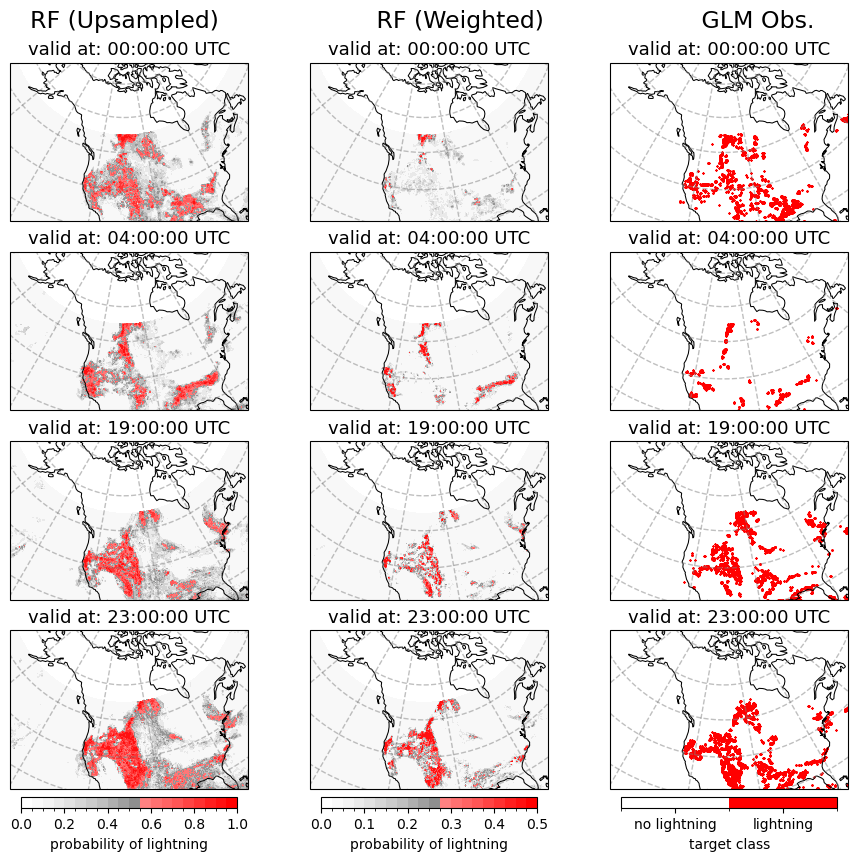

In [50]:
# the times to plot
time_lis = ['00','04','19','23']
res = '110m'
thresh_cmap = True
th_up = 0.573
th_w = 0.121

if thresh_cmap:
    cmap_up = make_custom_cmap(th_up)
    cmap_w = make_custom_cmap(th_w)
else:
    cmap_up = cmap_grey = mpl.cm.Greys
    cmap_w = cmap_grey = mpl.cm.Greys

# get the WRF projection 
proj = get_cartopy(lon)
projPC = ccrs.PlateCarree()

fig, ax = plt.subplots(4,3,
                        subplot_kw={'projection':proj},
                        constrained_layout=True,
                        figsize=(9,8.5)
                        )

tix = 0 # to index the time list 
for i in range(4): # rows
    for j in range(3): # columns

        tt = time_lis[tix]

        # the column of upsampled predictions for different times
        if j == 0:
            p1d = p_dict_up[f'p{tt}']
            p = stats.reconstruct_domain(p1d,shape)

            gl = ax[i,j].gridlines(
                draw_labels=False, linewidth = 1, color='gray', alpha=0.5, linestyle='--'
            )

            bounds = np.linspace(0.0,1,21)
            norm = mpl.colors.BoundaryNorm(bounds,cmap_up.N)

            ax[i,j].coastlines(resolution=res,linewidth=0.75)
            datap = ax[i,j].contourf(lon, lat, p, cmap=cmap_up, levels=np.linspace(0,1,10), transform=projPC)

            ax[i,j].set_xlim(cartopy_xlim(lon))
            ax[i,j].set_ylim(cartopy_ylim(lon))
            # ax[i,j].set_title(f'init: 00z June 6, 2024             valid at: {date[0]}/{date[1]}/{date[2]} {tt}:00:00 UTC', fontsize=6)
            ax[i,j].set_title(f'valid at: {tt}:00:00 UTC', fontsize=13)

            if i == 3: # set the colorbar  
                cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_up),
                    ax=ax[i,j],
                    orientation='horizontal', label='probability of lightning',
                    shrink=0.74
                    )
                cbar_ax = cbar.ax
                cbar_ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
                cbar_ax.set_xticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'])

        # the column of weighted predictions for different times
        if j == 1:
            p1d = p_dict_w[f'p{tt}']
            p = stats.reconstruct_domain(p1d,shape)

            gl = ax[i,j].gridlines(
                draw_labels=False, linewidth = 1, color='gray', alpha=0.5, linestyle='--'
            )

            max_val = 0.5
            bounds = np.linspace(0.0,max_val,21)
            norm = mpl.colors.BoundaryNorm(bounds,cmap_w.N)

            ax[i,j].coastlines(resolution=res,linewidth=0.75)
            datap = ax[i,j].contourf(lon, lat, p, cmap=cmap_w, levels=np.linspace(0,max_val,10), transform=projPC)

            ax[i,j].set_xlim(cartopy_xlim(lon))
            ax[i,j].set_ylim(cartopy_ylim(lon))
            # ax[i,j].set_title(f'init: 00z June 6, 2024             valid at: {date[0]}/{date[1]}/{date[2]} {tt}:00:00 UTC', fontsize=6)  
            ax[i,j].set_title(f'valid at: {tt}:00:00 UTC', fontsize=13)   

            if i == 3: # set the colorbar  
                cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_w),
                    ax=ax[i,j],
                    orientation='horizontal', label='probability of lightning',
                    shrink=0.74
                    )
                cbar_ax = cbar.ax
                cbar_ax.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5])
                cbar_ax.set_xticklabels(['0.0','0.1','0.2','0.3','0.4','0.5'])

        if j == 2:
            tt = time_lis[tix]

            gl = ax[i,j].gridlines(
                draw_labels=False, linewidth = 1, color='gray', alpha=0.5, linestyle='--'
            )

            ax[i,j].coastlines(resolution=res,linewidth=0.75)
            ax[i,j].scatter(lon_dict[f'lon{tt}'], lat_dict[f'lat{tt}'],color='r',marker='x',transform=projPC,s=1)

            ax[i,j].set_xlim(cartopy_xlim(lon))
            ax[i,j].set_ylim(cartopy_ylim(lon))
            # ax[i,j].set_title(f'init: 00z June 6, 2024            valid at: {date[0]}/{date[1]}/{date[2]} {tt}:00:00 UTC', fontsize=6)
            ax[i,j].set_title(f'valid at: {tt}:00:00 UTC', fontsize=13)

            if i == 3: # set the colorbar  
                cmap = mpl.colors.ListedColormap(['w','r'])
                bounds = [0,0.5,1]
                norm = mpl.colors.BoundaryNorm(bounds,cmap.N)

                cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    ax=ax[i,j],
                    orientation='horizontal', label='target class',
                    shrink=0.74
                    )
                cbar_ax = cbar.ax
                cbar_ax.set_xticks([0.25,0.75])
                cbar_ax.set_xticklabels(['no lightning','lightning'])
    tix+=1

plt.suptitle(      'RF (Upsampled)                     RF (Weighted)                     GLM Obs.  ',size=17)
plt.savefig('figures/CaseStudyThresh1.png',bbox_inches='tight')

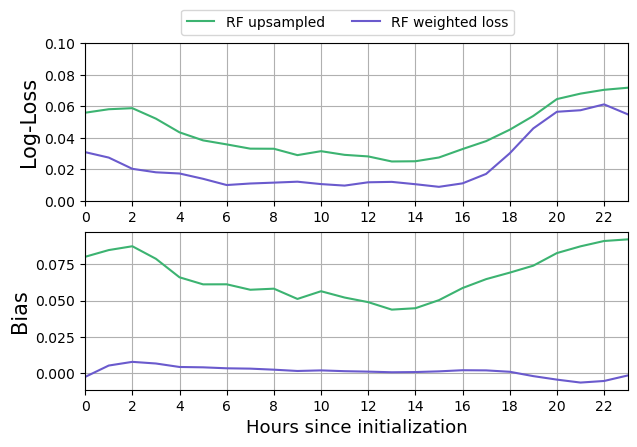

In [93]:
plot_times = np.arange(0,24,1)

# calculate Log-Loss timeseries
LLup = stats.calc_timeseries(test_dict,p_dict_up,calc_LogLoss,times)
LLw = stats.calc_timeseries(test_dict,p_dict_w,calc_LogLoss,times)

# calculate bias timeseries 
Biasup = stats.calc_timeseries(test_dict,p_dict_up,calc_bias,times)
Biasw = stats.calc_timeseries(test_dict,p_dict_w,calc_bias,times)

fig, ax = plt.subplots(2,1, figsize=(7,4.5))

ax[0].plot(plot_times,LLup, label='RF upsampled', color='mediumseagreen')
ax[0].plot(plot_times,LLw, label='RF weighted loss', color='slateblue')
ax[0].set_ylim(0,0.10)
ax[0].set_xlim(0,23)
ax[0].set_ylabel('Log-Loss', fontsize=15)
ax[0].set_xticks(np.arange(0,24,2))
ax[0].grid()

ax[1].plot(plot_times,Biasup, label='RF upsampled', color='mediumseagreen')
ax[1].plot(plot_times,Biasw, label='RF weighted loss', color='slateblue')

ax[1].set_xticks(np.arange(0,24,2))
ax[1].set_xticklabels(np.arange(0,24,2))

ax[1].set_xlabel('Hours since initialization', fontsize=13)
ax[1].set_ylabel('Bias', fontsize=15)
ax[1].set_xlim(0,23)
ax[1].grid()

fig.legend(*ax[0].get_legend_handles_labels(), loc='upper center', ncol=2, bbox_to_anchor=(0.5,0.97))

plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.savefig('figures/ProbablisticCaseStudy.png',bbox_inches='tight')

In [67]:
CSIup = calc_timeseries(test_dict,p_dict_up,stats.calc_CSI,times,th_up)
TPRup = calc_timeseries(test_dict,p_dict_up,stats.calc_TPR,times,th_up)
FPRup = calc_timeseries(test_dict,p_dict_up,stats.calc_FPR,times,th_up)
CSIw = calc_timeseries(test_dict,p_dict_w,stats.calc_CSI,times,th_w)
TPRw = calc_timeseries(test_dict,p_dict_w,stats.calc_TPR,times,th_w)
FPRw = calc_timeseries(test_dict,p_dict_w,stats.calc_FPR,times,th_w)

CSI_lis = [CSIup,CSIw,CSIup-CSIw]
TPR_lis = [TPRup,TPRw,TPRup-TPRw]
FPR_lis = [FPRup,FPRw,FPRup-FPRw]

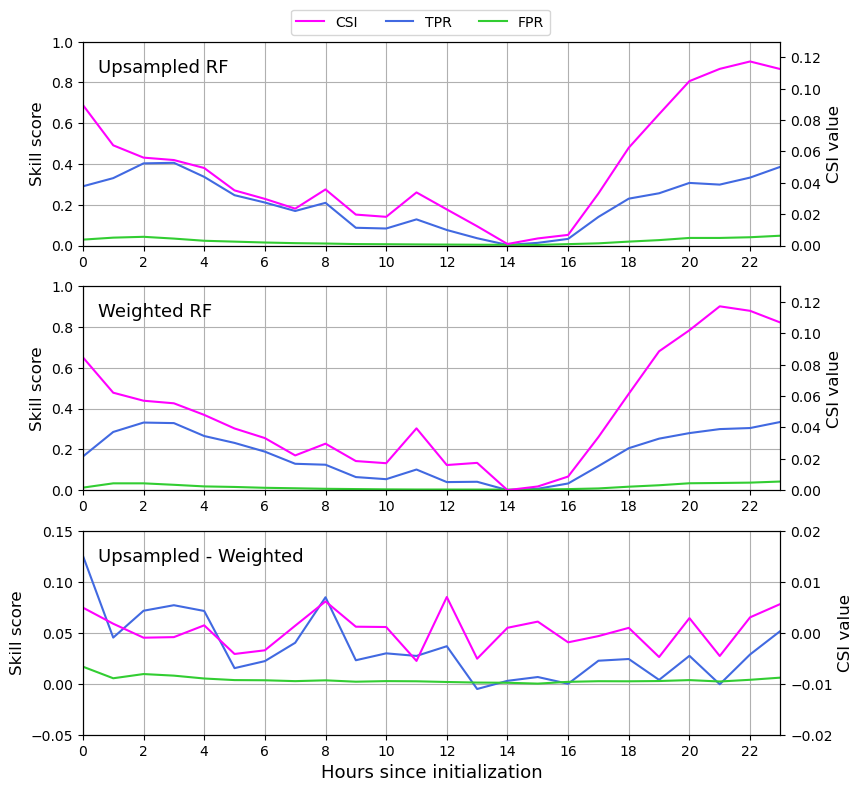

In [95]:
fig, ax = plt.subplots(3,1, figsize=(9,9))

for i in range(3):
    
    ax2 = ax[i].twinx()

    l1 = ax2.plot(plot_times, CSI_lis[i],label='CSI',color='fuchsia')
    l2 = ax[i].plot(plot_times, TPR_lis[i],label='TPR',color='royalblue')
    l3 = ax[i].plot(plot_times, FPR_lis[i],label='FPR',color='limegreen')

    ax[i].set_xlim(0,23)
    ax[i].set_ylabel('Skill score',fontsize=12)
    ax2.set_ylabel('CSI value',fontsize=12)
    ax[i].set_xticks(np.arange(0,24,2))
    ax[i].set_xticklabels(np.arange(0,24,2))
    ax[i].grid()

    if i==2:
        ax[i].set_ylim(-0.05,0.15)
        ax2.set_ylim(-0.02,0.02)
        ax[i].text(0.5,0.12,'Upsampled - Weighted',fontsize=13)
        ax[i].set_xlabel('Hours since initialization',fontsize=13)

    if i==1:
        ax[i].text(0.5,0.85,'Weighted RF',fontsize=13)
        ax2.set_ylim(0,0.13)
        ax[i].set_ylim(0,1)
    
    if i==0:
        ax[i].text(0.5,0.85,'Upsampled RF',fontsize=13)
        ax2.set_ylim(0,0.13)
        ax[i].set_ylim(0,1)

ls = l1+l2+l3
labs = [l.get_label() for l in ls]
fig.legend(ls,labs, loc='lower center', ncol=3,bbox_to_anchor=(0.5,0.88))
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.savefig('figures/DeterministicCaseStudy.png',bbox_inches='tight')

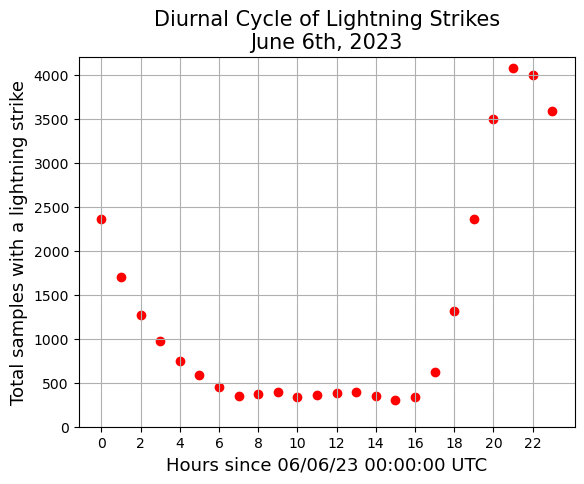

In [98]:
fig, ax = plt.subplots(1,1)

for tt in times:
    strikes = np.sum(test_dict[f'y{tt}'])
    ax.scatter(int(tt),strikes, color='red')

ax.set_title('Diurnal Cycle of Lightning Strikes\nJune 6th, 2023',fontsize=15)
ax.set_xlabel('Hours since 06/06/23 00:00:00 UTC',fontsize=13)
ax.set_ylabel('Total samples with a lightning strike',fontsize=13)
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(np.arange(0,24,2))
ax.set_ylim(0,4200)
ax.grid()
plt.savefig('figures/LightningCycle.png',bbox_inches='tight')